In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

In [3]:
df=pd.read_csv('final_features.csv')[:10000]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 797 entries, Unnamed: 0 to 383_y
dtypes: float64(782), int64(15)
memory usage: 60.8 MB


In [5]:
ytrue=df.iloc[:,2]
data=df.iloc[:,3:]

In [6]:
xtrain,xtest, ytrain, ytest = train_test_split(data, ytrue, stratify=ytrue, test_size=0.3)

In [7]:
print("Number of data points in train data :",xtrain.shape)
print("Number of data points in test data :",xtest.shape)

Number of data points in train data : (7000, 794)
Number of data points in test data : (3000, 794)


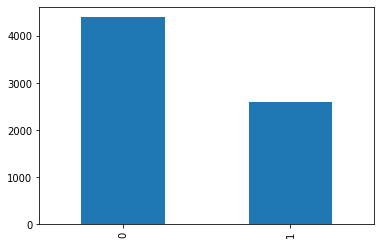

In [8]:
ytrain.value_counts().plot(kind='bar')

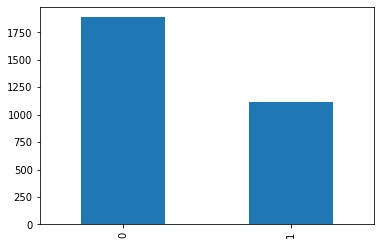

In [9]:
ytest.value_counts().plot(kind='bar')

In [10]:
def plot_hyperprm(log_error,alpha=[],penal='l2',clf=None):
    fig, ax = plt.subplots()
    ax.plot(alpha, log_error,c='g')
    #for i, txt in enumerate(np.round(log_error,3)):
        #ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()
    
    
    best_alpha = np.argmin(log_error)
    if clf is None:
        clf = SGDClassifier(alpha=alpha[best_alpha], loss='log', random_state=42,penalty=penal)
    clf.fit(xtrain, ytrain)
    c_clf = CalibratedClassifierCV(clf, method="sigmoid")
    c_clf.fit(xtrain, ytrain)
    predict_y = c_clf.predict_proba(xtrain)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(ytrain, predict_y, labels=clf.classes_))
    predict_y =c_clf.predict_proba(xtest)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(ytest, predict_y, labels=clf.classes_))
    predicted_y =np.argmax(predict_y,axis=1)
    print("Total number of data points :", len(predicted_y))
    print('Penalty is ',penal)
    plot_confusion_matrix(ytest, predicted_y)

LOGISTIC REGRESSION

Log loss for alpha = 1e-05 is  0.6594858906574843
Log loss for alpha = 0.0001 is  0.6594858906574843
Log loss for alpha = 0.001 is  0.5268273407572719
Log loss for alpha = 0.01 is  0.5230053083440863
Log loss for alpha = 0.1 is  0.5326596893189227
Log loss for alpha = 1 is  0.5215976634757054
Log loss for alpha = 10 is  0.5377582846687046


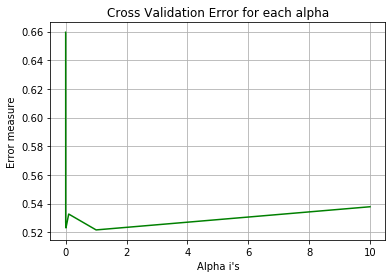

For values of best alpha =  1 The train log loss is: 0.4722831212544722
For values of best alpha =  1 The test log loss is: 0.5215976634757054
Total number of data points : 3000
Penalty is  l2


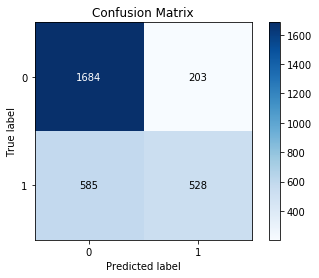

In [11]:
alpha=[10 ** x for x in range(-5,2)]
log_error=[]
for a in alpha:
    clf=SGDClassifier(loss='log',alpha=a,random_state=42)
    clf.fit(xtrain,ytrain)
    c_clf=CalibratedClassifierCV(clf)
    c_clf.fit(xtrain,ytrain)
    predicted_y=c_clf.predict_proba(xtest)
    l=log_loss(ytest,predicted_y,labels=clf.classes_)
    log_error.append(l)
    print('Log loss for alpha = {} is  {}'.format(a,l))
plot_hyperprm(log_error,alpha)    

LINEAR SVM

Log loss for alpha = 1e-05 is  0.6594858906574843
Log loss for alpha = 0.0001 is  0.6594858906574843
Log loss for alpha = 0.001 is  0.6594858906574843
Log loss for alpha = 0.01 is  0.6594858906574843
Log loss for alpha = 0.1 is  0.6314246931734387
Log loss for alpha = 1 is  0.6594858906574843
Log loss for alpha = 10 is  0.6392685529967912


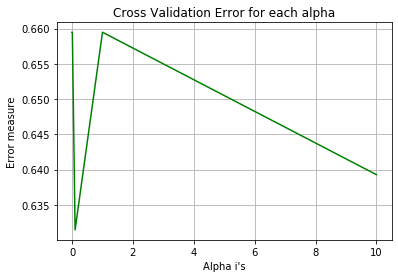

For values of best alpha =  0.1 The train log loss is: 0.626536911168095
For values of best alpha =  0.1 The test log loss is: 0.6314246931734387
Total number of data points : 3000
Penalty is  l2


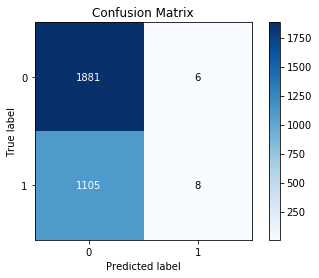

In [15]:
alpha=[10**x for x in range(-5,2)]
log_error=[]

for a in alpha:
    clf=SGDClassifier(loss='hinge',random_state=42,alpha=a,penalty='l1')
    clf.fit(xtrain,ytrain)
    c_clf=CalibratedClassifierCV(clf)
    c_clf.fit(xtrain,ytrain)
    y_prob=c_clf.predict_proba(xtest)
    l=log_loss(ytest,y_prob,labels=clf.classes_)
    log_error.append(l)
    print('Log loss for alpha = {} is  {}'.format(a,l))
clf=SGDClassifier(loss='hinge',random_state=42,alpha=alpha[np.argmin(log_error)],penalty='l1')    
plot_hyperprm(log_error,alpha,clf=clf)

In [16]:
import xgboost as xgb

In [17]:
params = {}
#eta=[i**x for x in range(-2,0) for i in [1,2,3]]
#eta=[0.002,0.001,0.01,0.02]
#eta=[0.020,0.022,0.025,0.026,0.028]
eta=[0.0280,0.0285,0.0290,0.0295]
max_depth=[4]
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
x={}
for e in eta:
    for d in max_depth:
        params['eta'] = e
        params['max_depth'] = d
        print('\n\n\t For eta={}\t max_depth={} \n\n\n'.format(e,d))
        d_train = xgb.DMatrix(xtrain, label=ytrain)
        d_test = xgb.DMatrix(xtest, label=ytest)

        watchlist = [(d_train, 'train'), (d_test, 'valid')]

        bst = xgb.train(params, d_train, 600, watchlist, early_stopping_rounds=20, verbose_eval=10)

        xgdmat = xgb.DMatrix(xtrain,ytrain)
        predict_y = bst.predict(d_test)
        l=log_loss(ytest, predict_y, labels=clf.classes_)
        x[str(e)+','+str(d)]=l
        print("The test log loss is:",l,"   ",e,d)
        # plot feature importance
        #xgb.plot_importance(bst)
        #plt.show()



	 For eta=0.028	 max_depth=4 



[0]	train-logloss:0.681007	valid-logloss:0.68146
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.58809	valid-logloss:0.592403
[20]	train-logloss:0.527505	valid-logloss:0.535228
[30]	train-logloss:0.485056	valid-logloss:0.49638
[40]	train-logloss:0.45436	valid-logloss:0.469113
[50]	train-logloss:0.431319	valid-logloss:0.449083
[60]	train-logloss:0.413851	valid-logloss:0.43461
[70]	train-logloss:0.400127	valid-logloss:0.423676
[80]	train-logloss:0.38908	valid-logloss:0.414832
[90]	train-logloss:0.380002	valid-logloss:0.408298
[100]	train-logloss:0.37215	valid-logloss:0.403259
[110]	train-logloss:0.364667	valid-logloss:0.398848
[120]	train-logloss:0.35811	valid-logloss:0.395508
[130]	train-logloss:0.352315	valid-logloss:0.392444
[140]	train-logloss:0.347273	valid-logloss:0.389678
[150]	train-logloss:0.34194	valid-logloss:0.387292
[1

In [ ]:
#xold
#x = dict(x, **xold); d4.update(d3)
x = dict(x, **xold)
#best -  [0.02 ,4/8]

In [18]:
x

{'0.028,4': 0.36893543983697114,
 '0.0285,4': 0.3674354649636565,
 '0.029,4': 0.3675789892799706,
 '0.0295,4': 0.367145131099552}

In [19]:
#best logloss
eta=[0.0295]
max_depth=[4]
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
x={}
for e in eta:
    for d in max_depth:
        params['eta'] = e
        params['max_depth'] = d
        print('\n\n\t For eta={}\t max_depth={} \n\n\n'.format(e,d))
        d_train = xgb.DMatrix(xtrain, label=ytrain)
        d_test = xgb.DMatrix(xtest, label=ytest)

        watchlist = [(d_train, 'train'), (d_test, 'valid')]

        bst = xgb.train(params, d_train, 600, watchlist, early_stopping_rounds=20, verbose_eval=10)

        xgdmat = xgb.DMatrix(xtrain,ytrain)
        predict_y = bst.predict(d_test)
        l=log_loss(ytest, predict_y, labels=clf.classes_)
        #x[str(e)+','+str(d)]=l
        print("The test log loss is:",l,"   ",e,d)



	 For eta=0.0295	 max_depth=4 



[0]	train-logloss:0.680368	valid-logloss:0.680844
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.583602	valid-logloss:0.588071
[20]	train-logloss:0.521971	valid-logloss:0.53012
[30]	train-logloss:0.479142	valid-logloss:0.490948
[40]	train-logloss:0.448791	valid-logloss:0.46418
[50]	train-logloss:0.426216	valid-logloss:0.444305
[60]	train-logloss:0.40902	valid-logloss:0.430411
[70]	train-logloss:0.395857	valid-logloss:0.419865
[80]	train-logloss:0.385084	valid-logloss:0.411841
[90]	train-logloss:0.375955	valid-logloss:0.405541
[100]	train-logloss:0.3681	valid-logloss:0.400625
[110]	train-logloss:0.360737	valid-logloss:0.396783
[120]	train-logloss:0.354287	valid-logloss:0.393259
[130]	train-logloss:0.349073	valid-logloss:0.390442
[140]	train-logloss:0.343196	valid-logloss:0.38776
[150]	train-logloss:0.337938	valid-logloss:0.38591

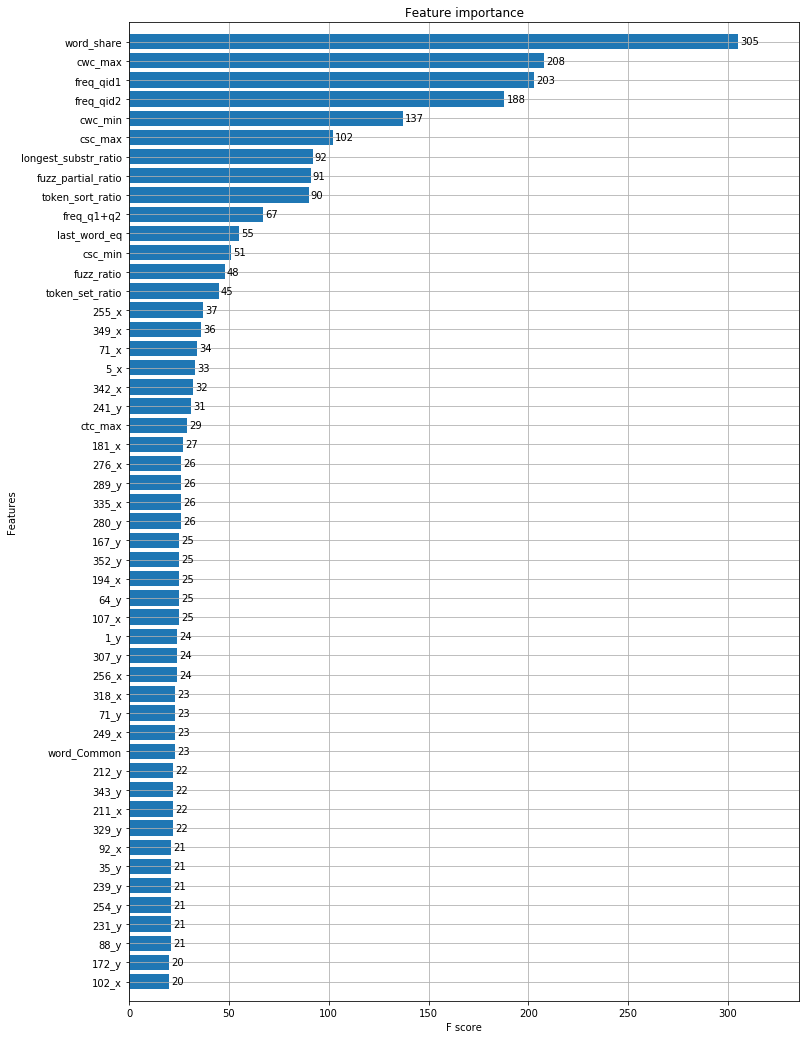

In [20]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=50, height=0.8, ax=ax)
plt.show()